### Radial velocity computation with self-calibrated files

Not finished.

In [3]:
# Import my .py code 
# Run this to reimport without having to restart the whole notebook
import calibration_functions
import importlib
importlib.reload(calibration_functions)
from calibration_functions import *

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import tqdm as tqdm
import pandas as pd

plt.rcParams['font.size'] = 16
plt.rc("font", family="serif")

from os import walk


In [5]:
mypath = "/Users/jakobharteg/kDrive/Uni/Kurser/Bachelorprojekt/Data/EXPRES_spectra/spectra"
filenames = next(walk(mypath), (None, None, []))[2]  # [] if no file

In [6]:
def sort_last_digits(elem):
    return elem[elem.index(".") + 1:]

spectra = []
spectra_err = []
wavel = []

for file in sorted(filenames, key=sort_last_digits):
    data = fits.open(mypath + "/" + file)[1].data.copy()
    
    # Start for one order
    order = 45
    
    data_spec       = data['spectrum'][order]
    data_spec_err   = data['uncertainty'][order]
    data_wavel      = data['wavelength'][order]
    spectra.append(data_spec)
    spectra_err.append(data_spec_err)
    wavel.append(data_wavel)

    # fig, ax = plt.subplots(figsize=(16,2))
    # ax.set_title(f"{file}")
    # ax.plot(data_wavel, data_spec)


spectra = np.asarray(spectra)
spectra_err = np.asarray(spectra_err)
wavel = np.asarray(wavel)

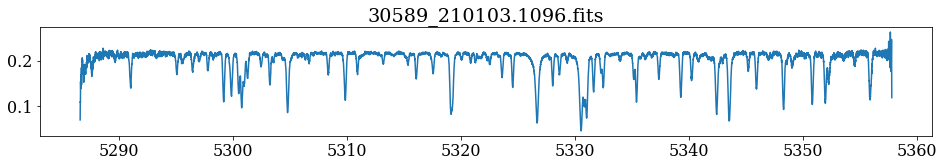

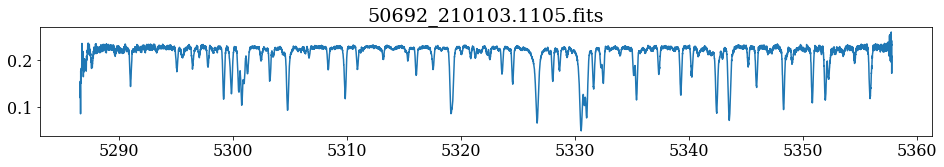

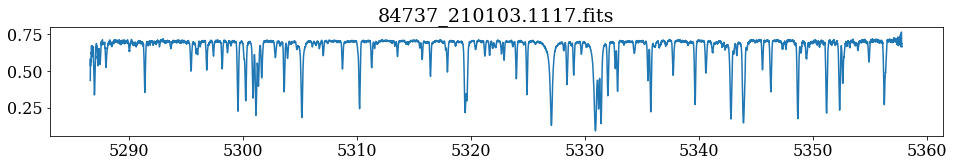

In [7]:
# Print first three: 
for s, w, f in zip(spectra[0:3], wavel[0:3], filenames[0:3]):
    fig, ax = plt.subplots(figsize=(16,2))
    ax.set_title(f"{f}")
    ax.plot(w, s)

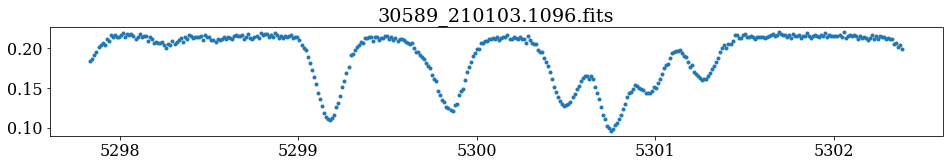

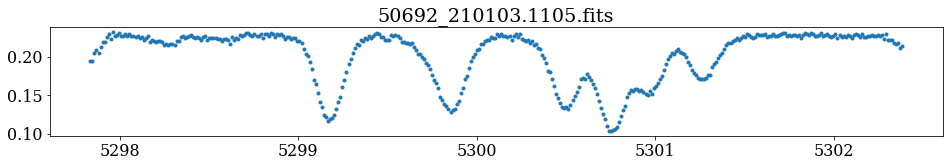

In [8]:
# Print first three: 
for s, w, f in zip(spectra[0:2], wavel[0:2], filenames[0:2]):
    fig, ax = plt.subplots(figsize=(16,2))
    ax.set_title(f"{f}")
    ax.plot(w[1100:1500], s[1100:1500], ".")




#### Manual Chi2

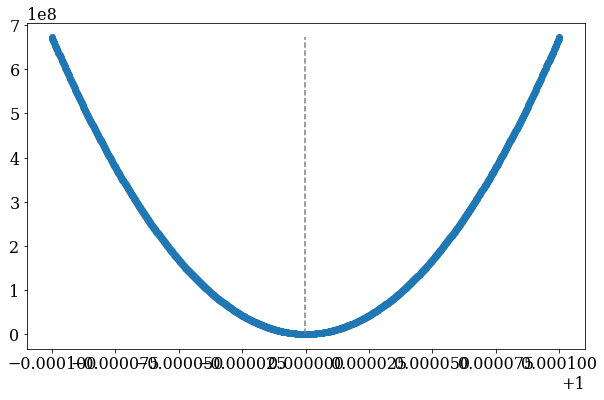

In [98]:

s0, s_err0, w0, f0 = spectra[0], spectra_err[0], wavel[0], filenames[0]
s1, s_err1, w1, f1 = spectra[1], spectra_err[1], wavel[1], filenames[1]

# create shift templates
shift_interval = np.linspace(0.9999, 1.0001, 1000)
t1_template = [w0 * shift for shift in shift_interval]


def chi2(wavel1, wavel1_err, wavel2_template) :
    return np.sum(((wavel1 - wavel2_template) / wavel1_err)**2)


# Compute chi2
chi2s = [chi2(w1[s_err1 > 0], s_err1[s_err1 > 0], x[s_err1 > 0]) for x in t1_template ]

# Plot the parabola
plt.figure(figsize=(10,6))
plt.plot(shift_interval, chi2s, "o")
x_min = shift_interval[np.argmin(chi2s)]
plt.vlines(x_min, 0, max(chi2s), linestyles="dashed", color="grey")
# plt.ylim(min(chi2s) - 1, min(chi2s) + 5)
# plt.xlim(0.999999991, 1.00000001)

### Calibrate each order

In [68]:
def sort_last_digits(elem):
    return elem[elem.index(".") + 1:]


LFC_path = "/Users/jakobharteg/kDrive/Uni/Kurser/Bachelorprojekt/Data/EXPRES_spectra/LFC"
SPECTRA_path = "/Users/jakobharteg/kDrive/Uni/Kurser/Bachelorprojekt/Data/EXPRES_spectra/spectra"

def load_all_files():
    """ Returns matrix of LFC_filenames and SPEKTRA_filenames sorted by the digits after the last
        period point in the file name"""

    LFC_filenames = next(walk(LFC_path), (None, None, []))[2]  # [] if no file
    LFC_filenames = sorted(LFC_filenames, key=sort_last_digits)
    
    SPEKTRA_filenames = next(walk(SPECTRA_path), (None, None, []))[2]  # [] if no file
    SPEKTRA_filenames = sorted(SPEKTRA_filenames, key=sort_last_digits)
    
    return np.column_stack([LFC_filenames[:10], SPEKTRA_filenames[:10]]) # TODO only loading first 10 files, ammend for real data.
    

CALIB_path = "calib_files"
def load_calib_filenames():
    CALIB_filenames = next(walk(CALIB_path), (None, None, []))[2]  # [] if no file
    CALIB_filenames = sorted(CALIB_filenames, key=sort_last_digits)
    CALIB_filenames = [x for x in CALIB_filenames if x.__contains__(".parquet")] # only take .parquet files 
    return CALIB_filenames


def load_calib_parquets():
    filenames = load_calib_filenames()
    files = []
    for name in filenames:
        files.append(pd.read_parquet(CALIB_path + "/" + name))    
    return files

def interpolate_LFC(data):
    """ Returns ndarray of interpolation functions for each order in data file """

    interp_functions = []
    n_orders = len(LFC_data)
    for order in np.arange(n_orders):
        data_spec       = data['spectrum'][order]
        data_spec_err   = data['uncertainty'][order]
        data_wavel      = data['wavelength'][order]

        # Find peaks
        peak_info = func_find_peaks(data_spec, 11, 0.15)
        peak_locs = peak_info[0]

        if len(peak_locs) < 10:
            continue

        # Create data slices around each peak
        peak_index_ranges = get_peak_index_ranges(peak_locs)

        # Fit peak in each data slice
        peak_fits = fit_peaks(data_spec, data_spec_err, peak_index_ranges)

        # Get list of true wavelengths
        wavel_true = get_true_wavel(data_wavel, peak_locs)[:, 0] # second column is the n in the true wavel peak formula

        x = peak_fits[:,2]
        y = wavel_true

        # Interpolate
        interp_functions.append([interpolate_order(x, y), order])

    return np.asarray(interp_functions)


def plot_calib(calib_func, order, data):
    
    def plot(ax):
        ax.set_title(f"{order}. order")
        
        # Plot original data with wavelength on x, so we can compare to calibration
        y = data['spectrum'][order]
        x = data['wavelength'][order]
        ax.plot(x, y, label="Original data")
        
        # apply calibration (pix --> wavelength),  pix is just the index position 
        x_calib = calib_func(range(len(y)))

        # Plot calibrated
        ax.plot(x_calib, y + 0.05, label="Calibrated data")

        ax.set_xlabel("Wavelength [Å]")
        ax.set_ylabel("Intensity")
        ax.legend()


    fig, ax = plt.subplots(figsize=(18,4))
    plot(ax)

    # fig, ax = plt.subplots(figsize=(18,4))
    # plot(ax)

    # x = data['wavelength'][order]
    # middle = int(min(x) + ((max(x) - min(x)) / 2))
    # ax.set_xlim(middle - 1, middle + 1)


In [104]:
# TODO Don't know which speaktra match with which LFC files, so just building code for now

calib_data = load_all_files()
for d in tqdm.tqdm(calib_data):

    # Open LFC and do interpolation
    LFC_filename = LFC_path  + "/" + d[0]
    LFC_hdul = fits.open(LFC_filename)
    LFC_data = LFC_hdul[1].data.copy()
    interp_functions = interpolate_LFC(LFC_data)
    LFC_hdul.close()

    # Open spectrum file
    SPECTRUM_filename = SPECTRA_path  + "/" + d[1]
    SPECTRUM_hdul = fits.open(SPECTRUM_filename)
    SPECTRUM_data = SPECTRUM_hdul[1].data.copy()
    SPECTRUM_hdul.close()
    
    # Loop through available calibration/interp functions (only available for "good" orders)
    calib_file = []
    for calib_func in interp_functions:
        func, order = calib_func
        
        # plot_calib(func, order, SPECTRUM_data)

        # Apply callibration
        x = SPECTRUM_data['wavelength'][order]
        I = SPECTRUM_data['SPECTRUM'][order]
        I_err = SPECTRUM_data['UNCERTAINTY'][order]
        x_calib = func(range(len(x)))

        # Append as matrix 
        calib_file.append(np.column_stack([x_calib, I, I_err, [order] * len(x)]))

    # Stack all matrices, such that each data point is its own row
    calib_file = np.vstack(calib_file)
    df = pd.DataFrame(calib_file)
    df.columns = ["x_calib", "spectrum", "spectrum_err", "order"]
    df.to_parquet(f'calib_files/{d[1]}_calib.parquet')

100%|██████████| 10/10 [06:49<00:00, 40.95s/it]


### Template fitting calibrated data

This creates a list of: 

file > order_data > dataframe(x_calib, spectrum, spectrum_err, order)

In [967]:
def load_calib_files1():
    data = []
    for file in load_calib_filenames():
        
        # load file into dataframe
        df = pd.read_parquet(CALIB_path + "/" + file)

        # Get lowest and highest order
        order_min, order_max = min(df.order), max(df.order)

        # separate into orders
        d = []
        for order_n in np.arange(order_min, order_max):
            d.append(df[df.order == order_n])

        data.append(np.asarray(d))
    return data


def load_calib_files1a():
    data = []
    for file in load_calib_filenames():
        
        # load file into dataframe
        df = pd.read_parquet(CALIB_path + "/" + file)

        # Get lowest and highest order
        order_min, order_max = min(df.order), max(df.order)

        # separate into orders
        orders_available = np.arange(order_min, order_max)
        
        d = []
        d = np.zeros((len(orders_available)), dtype=object)
        d[:] = np.nan

        for order_n in orders_available:
            d.append(df[df.order == order_n])
            d.append(df[df.order == order_n])

        data.append(d)
    return data

In [966]:
# TODO: this replaces the previous cell

def load_calib_files2():
    data = []
    for file in load_calib_filenames():
        # load file into dataframe
        df = pd.read_parquet(CALIB_path + "/" + file)

        # Get lowest and highest order
        order_min, order_max = min(df.order), max(df.order)

        # separate into orders
        d = np.zeros((int(order_max + 1)), dtype=object)
        d[:] = np.nan
        for order in unique(df.order):
            order = int(order)
            d[order] = df[df.order == order]
        data.append(d)
    return data


# TODO: this replaces the previous cell


def load_calib_files2a():
    data = []
    for file in load_calib_filenames():
        # load file into dataframe
        df = pd.read_parquet(CALIB_path + "/" + file)

        # Get highest order
        order_max = max(df.order)

        # separate into orders
        d = np.zeros((int(order_max + 1)), dtype=object)
        d[:] = np.nan
        for order in unique(df.order):
            order = int(order)
            d[order] = df[df.order == order]
        data.append(d)
    return data




So we now have 10 data sets and we can compute the shift between every data set. That gives us a 10x10 anti-symmetric matrix.


$$
\lambda_{template} = \lambda_2 \times [0.9999, 1.0001]
$$

$$
\chi^2 = \sum \frac{\lambda_1 - \lambda_{template}}{\sigma_{\lambda_1}}
$$

In [1078]:
# OLD Chi2 minimisation function OLD
def chi2_shift_minimiser_OLDOLDOLD(oberservation1, oberservation2, plot=False, order_method=1):

    if order_method == 1:
        Norders = np.nanmin([len(oberservation1), len(oberservation2)])
    elif order_method == 2:
        # Get last common order      [-1] = last order, get order value 
        Norders = np.nanmin(oberservation1[-1].order.values[0], oberservation2[-1].order.values[0])

    # print(Norders)

    # Loop through orders:
    # x_mins = []
    x_mins_minuit = []
    x_mins_minuit_err = []
    fit_converged = []

    orders_run = []
    for order in np.arange(Norders):

        obs1 = oberservation1[order]
        obs2 = oberservation2[order]

        # Data we need will be nan (and give error) for orders without data
        try:
            wavelength = obs1.x_calib
            wavelength_err = obs1.spectrum_err
            next_wavelength = obs2.x_calib
        except:
            x_mins_minuit.append(np.nan)
            x_mins_minuit_err.append(np.nan)
            continue
        
        orders_run.append(order)

        # Filter out points with no error
        # wavelength = wavelength[wavelength_err > 0] 
        # # next_wavelength = next_wavelength[wavelength_err > 0]
        # wavelength_err = wavelength_err[wavelength_err > 0]

        # Error is too small — multiply by sqrt(3)
        wavelength_err = wavelength_err * np.sqrt(3)

        # iMinuit #### 
        def func_template(x, A) :
            return x * A

        # ChiSquare fit model:
        def model_chi2(A):
            y_fit = func_template(next_wavelength, A)
            return np.sum(((wavelength - y_fit) / wavelength_err)**2)
        model_chi2.errordef = 1

        minuit = Minuit(model_chi2, A=1)
        minuit.migrad()                                             

        # print(minuit.valid)
        fit_converged.append(minuit.valid)
        
        A_fit = minuit.values['A']
        x_mins_minuit.append(1 - A_fit)
        
        sigma_A_fit = minuit.errors['A']
        x_mins_minuit_err.append(sigma_A_fit)

    # print(orders_run)

    fit_converged = np.asarray(fit_converged)    
    convergence_ratio = len(fit_converged[fit_converged])/len(fit_converged)

    return np.nanmean(x_mins_minuit), np.nanmean(x_mins_minuit_err), convergence_ratio 
    # return x_mins_minuit


In [10]:
# Chi2 minimisation function (for x calib posibly wrong)
def chi2_shift_minimiser_XCALIB(df_obs1, df_obs2, plot=False):

    # Loop through orders:
    x_mins_minuit = []
    x_mins_minuit_err = []
    fit_converged = []
    
    # Find orders
    orders1 = unique(df_obs1.order) # orders in file 1
    orders2 = unique(df_obs2.order) # orders in file 2
    common_orders = set(orders1).intersection(orders2) # orders in common to both files

    for order in common_orders:

        obs1_order = df_obs1[df_obs1.order == order]
        obs2_order = df_obs2[df_obs2.order == order]

        wavelength = obs1_order.x_calib
        wavelength_err = obs1_order.spectrum_err
        next_wavelength = obs2_order.x_calib

        # Filter out points with no error
        # wavelength = wavelength[wavelength_err > 0] 
        # # next_wavelength = next_wavelength[wavelength_err > 0]
        # wavelength_err = wavelength_err[wavelength_err > 0]

        # Error is too small — multiply by sqrt(3)
        wavelength_err = wavelength_err * np.sqrt(3)

        # iMinuit #### 
        def func_template(x, A) :
            return x * A

        # ChiSquare fit model:
        def model_chi2(A):
            y_fit = func_template(next_wavelength, A)
            return np.sum(((wavelength - y_fit) / wavelength_err)**2)
        model_chi2.errordef = 1

        minuit = Minuit(model_chi2, A=1)
        minuit.migrad()                                             

        # print(minuit.valid)
        fit_converged.append(minuit.valid)
        
        A_fit = minuit.values['A']
        x_mins_minuit.append(1 - A_fit)
        
        sigma_A_fit = minuit.errors['A']
        x_mins_minuit_err.append(sigma_A_fit)

    # print(orders_run)

    fit_converged = np.asarray(fit_converged)    
    convergence_ratio = len(fit_converged[fit_converged])/len(fit_converged)

    return np.nanmean(x_mins_minuit), np.nanmean(x_mins_minuit_err), convergence_ratio 
    # return x_mins_minuit


# Chi2 minimisation function
def chi2_shift_minimiser(df_obs1, df_obs2):

    # Loop through orders:
    x_mins_minuit = []
    x_mins_minuit_err = []
    fit_converged = []
    
    # Find orders
    orders1 = unique(df_obs1.order) # orders in file 1
    orders2 = unique(df_obs2.order) # orders in file 2
    common_orders = set(orders1).intersection(orders2) # orders in common to both files

    for order in common_orders:

        obs1_order = df_obs1[df_obs1.order == order]
        obs2_order = df_obs2[df_obs2.order == order]

        y1 = obs1_order.spectrum
        y1_err = obs1_order.spectrum_err # * np.sqrt(3)
        y2 = obs2_order.spectrum

        # wavelength = obs1_order.x_calib
        # wavelength_err = obs1_order.spectrum_err
        # next_wavelength = obs2_order.x_calib

        # iMinuit #### 
        def func_template(x, A) :
            return x * A

        # ChiSquare fit model:
        def model_chi2(A):
            y_fit = func_template(y2, A)
            return np.sum(((y1 - y_fit) / y1_err)**2)
        model_chi2.errordef = 1

        minuit = Minuit(model_chi2, A=1)
        minuit.migrad()                                             

        # Append results
        fit_converged.append(minuit.valid)
        x_mins_minuit.append(1 - minuit.values['A'])
        x_mins_minuit_err.append(minuit.errors['A'])

    
    # compute convergence ratio
    fit_converged = np.asarray(fit_converged)    
    convergence_ratio = len(fit_converged[fit_converged])/len(fit_converged)

    return np.nanmean(x_mins_minuit), np.nanmean(x_mins_minuit_err), convergence_ratio 

In [11]:
files = load_calib_parquets()
chi2_shift_minimiser(files[0], files[1])

# for i in np.arange(8):
#     print(f"For {i} with {i + 1}:", chi2_shift_minimiser(files[i], files[i + 1], plot = False))

(0.040772897150251806, 9.073459932195722e-05, 1.0)

In [ ]:
# Loads real spectra from EXPREES (Lily) for star HD34411
REAL_SPECTRA_path = "/Users/jakobharteg/Data/34411_spectra/"
def get_all_spectra_filenames():
    SPEKTRA_filenames = next(walk(REAL_SPECTRA_path), (None, None, []))[2]  # [] if no file
    SPEKTRA_filenames = sorted(SPEKTRA_filenames)
    return SPEKTRA_filenames


# Load data from fits file for a given "real spectra file"
def load_spectra_fits(filename):
    path = REAL_SPECTRA_path  + "/" + filename
    hdul = fits.open(path)
    data = hdul[1].data.copy()
    hdul.close()
    return data

(5090.0, 5091.0)

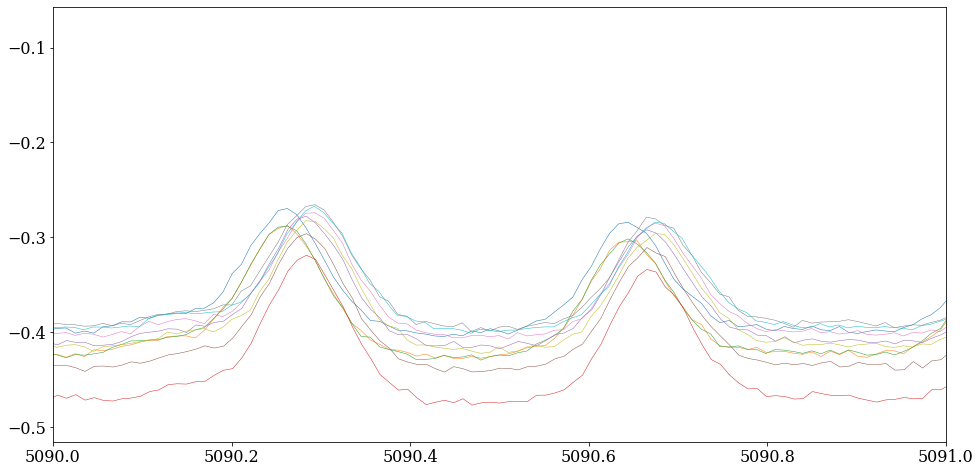

In [92]:
filenames = get_all_spectra_filenames()

plt.figure(figsize=(16,8))
for i in np.arange(0, 10):

    SPECTRA_DATA = load_spectra_fits(filenames[i])
    order = 40
    data_spec       = -SPECTRA_DATA['spectrum'][order]
    data_spec_err   = SPECTRA_DATA['uncertainty'][order]
    data_wavel      = SPECTRA_DATA['wavelength'][order]
    plt.plot(data_wavel, data_spec/np.nanmax(data_spec), linewidth=0.5)

plt.xlim(5090, 5091)

### The Matrix

In [60]:
files = load_calib_parquets()
size = len(files)
diff_matrix, diff_matrix_err = np.empty((size,size)), np.empty((size,size))
diff_matrix[:], diff_matrix_err[:] = np.nan, np.nan

for x in tqdm.tqdm(np.arange(size)):
    for y in np.arange(x, size):
        diff, err, valid = chi2_shift_minimiser(files[x], files[y])
        diff_matrix[x, y] = diff
        diff_matrix_err[x, y] = err

100%|██████████| 10/10 [01:02<00:00,  6.26s/it]


Text(0.5, 1.0, 'Error')

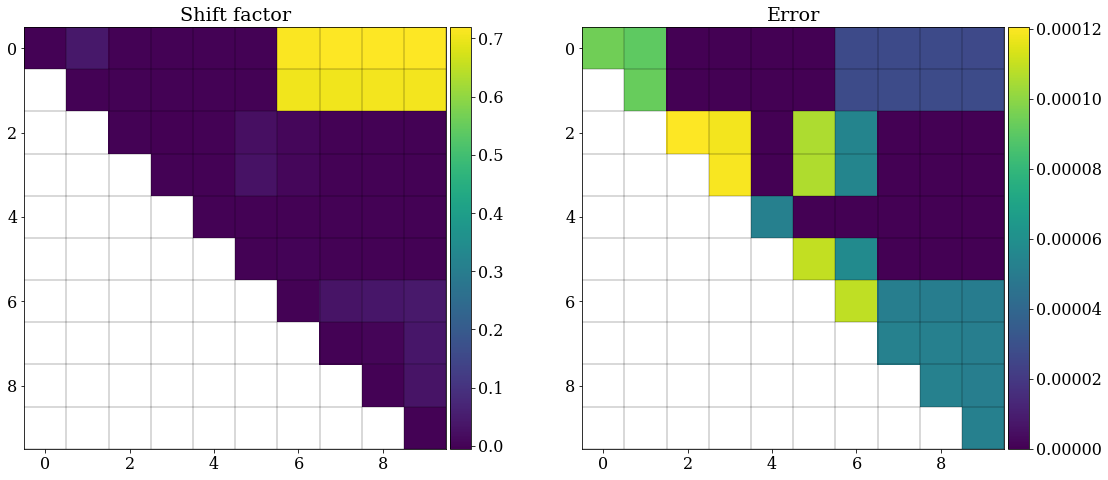

In [61]:
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,10))
cs = ax1.imshow(diff_matrix)
cax = make_axes_locatable(ax1).append_axes('right', size='5%', pad=0.05) # to make color bar same height at plot, needed when making several subplots with each colorbar
cbar = fig.colorbar(cs, ax=ax1, cax=cax)

# Grid lines hack 
length = len(diff_matrix)
ax1.hlines(y=np.arange(0, length)+0.5, xmin=np.full(length, 0)-0.5, xmax=np.full(length, length)-0.5, color="black", alpha=0.2)
ax1.vlines(x=np.arange(0, length)+0.5, ymin=np.full(length, 0)-0.5, ymax=np.full(length, length)-0.5, color="black", alpha=0.2)

# Matrix with errors
cs = ax2.imshow(diff_matrix_err)
cax = make_axes_locatable(ax2).append_axes('right', size='5%', pad=0.05) # to make color bar same height at plot, needed when making several subplots with each colorbar
cbar = fig.colorbar(cs, ax=ax2, cax=cax)

# Grid lines hack 
length = len(diff_matrix_err)
ax2.hlines(y=np.arange(0, length)+0.5, xmin=np.full(length, 0)-0.5, xmax=np.full(length, length)-0.5, color="black", alpha=0.2)
ax2.vlines(x=np.arange(0, length)+0.5, ymin=np.full(length, 0)-0.5, ymax=np.full(length, length)-0.5, color="black", alpha=0.2)

# Fix spacing between plots
# fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
fig.subplots_adjust(wspace=0.25)

ax1.set_title("Shift factor")
ax2.set_title("Error")


#### It should look like this: 

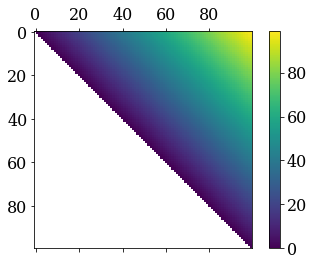

In [222]:
size = 100
# Gen 100 random numbers
numbers = np.random.rand(size)
numbers = np.arange(size)
diff_matrix = np.zeros((size,size))
diff_matrix[:] = np.nan

for x in range(size):
    for y in range(x, size):
        diff_matrix[x, y] = numbers[y] - numbers[x]


fig, ax = plt.subplots()
cax = ax.matshow(diff_matrix)
fig.colorbar(cax)

### Feature based

In [28]:

def find_features(file, plot_orders = None, plot_features_in_order = None):
    all_peaks = []
    all_feature_slices = []

    orders = unique(file.order)
    # for i in np.arange(len(file))[5:6]:
    # for i in np.arange(len(file)):
    for order in orders:
        
        x = np.array(file[file.order == order].x_calib)
        y = 1-np.array(file[file.order == order].spectrum)
        
        min_peak_dist = 50
        min_peak_prominence = 0.05
        peaks = func_find_peaks(y, min_peak_dist, min_peak_prominence)
        peak_locs = peaks[0]
        peak_height = peaks[5] # peak height from y=0 
        all_peaks.append(peak_locs)

        # Plot
        if plot_orders is not None and (plot_orders == order).any():
            plt.figure(figsize=(30,5))
            plt.plot(x, y)
            plt.plot(x[peak_locs], peak_height, "o", color="C3", label=f"{order}. order")
            # plt.plot(x[peak_locs], peak_height, "o", color="C3")
            plt.legend(loc = "upper right")

        # If less than 10 peaks skip order
        if len(peak_locs) < 5:
            all_feature_slices.append([np.nan, order])
            continue

        peak_index_ranges = get_peak_index_ranges(peak_locs, peak_range_size=50)

        feature_slices = []
        for index, range in enumerate(peak_index_ranges):
            start, end = range
            feature_slices.append([x[start:end], y[start:end]])

            if plot_features_in_order is not None and (plot_features_in_order == order).any():
                plt.figure(figsize=(10,3))
                plt.plot(x[start:end], y[start:end], ".")
                plt.plot(x[peak_locs[index]], peak_height[index], "o", color="C3", label=f"$k = {index}$")
                plt.legend(loc = "upper right")
        
        all_feature_slices.append([feature_slices, order])

    all_peaks = np.concatenate(all_peaks)
    print(len(all_peaks), "peaks found")

    return np.asarray(all_feature_slices, dtype=object)

1126 peaks found
1164 peaks found


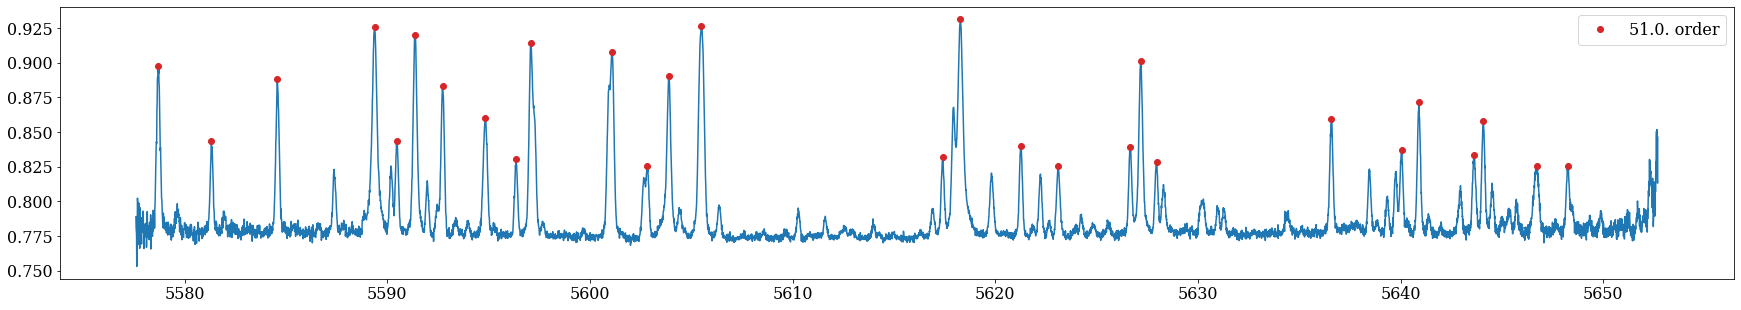

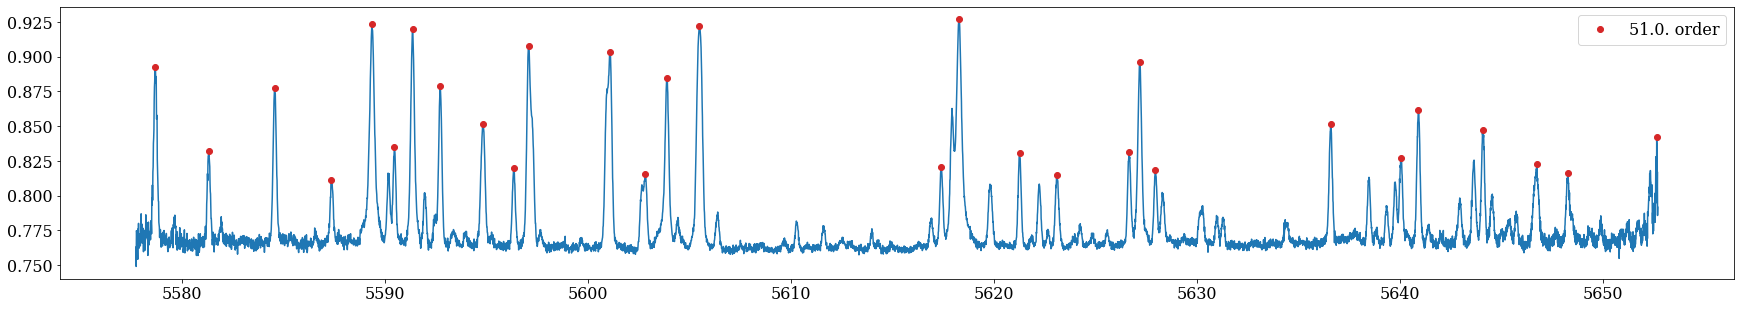

In [58]:
files = load_calib_parquets()
# d1 = find_features(files[0], plot_orders = [40], plot_features_in_order=[40])
n = 51
d1 = find_features(files[0], plot_orders = [n])
d1 = find_features(files[1], plot_orders = [n])

1126 peaks found
1164 peaks found
28


/var/folders/pd/q4f8j97x0gv_zjtmdgf4r3g00000gn/T/ipykernel_65592/1319267224.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(8, 4))


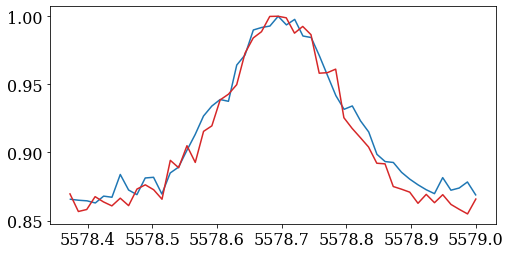

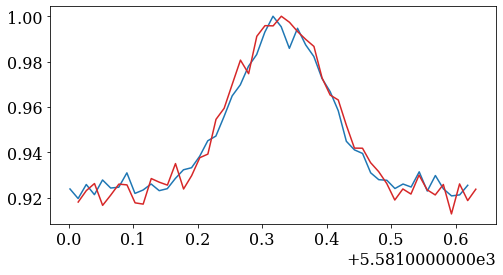

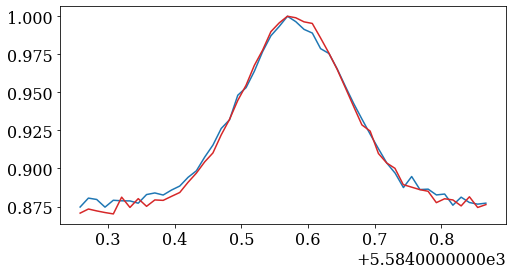

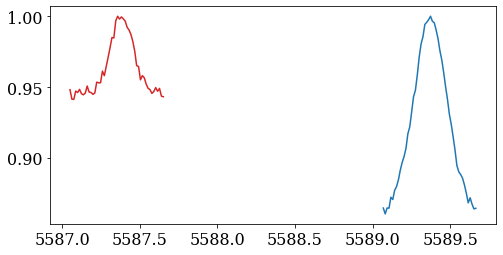

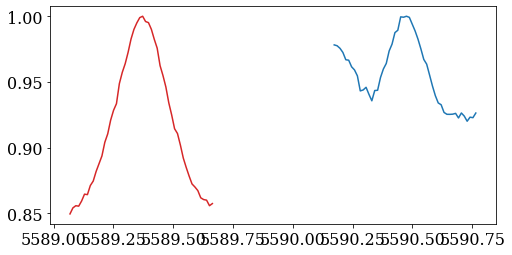

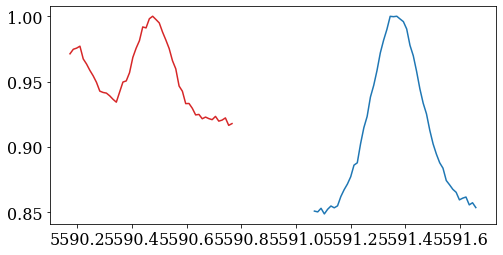

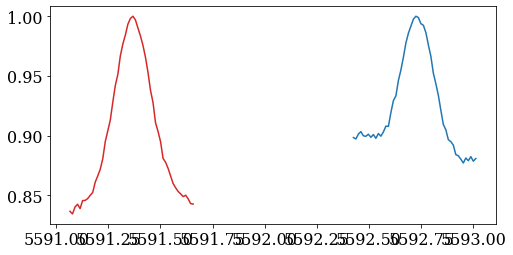

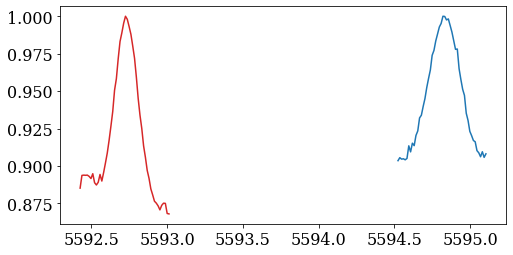

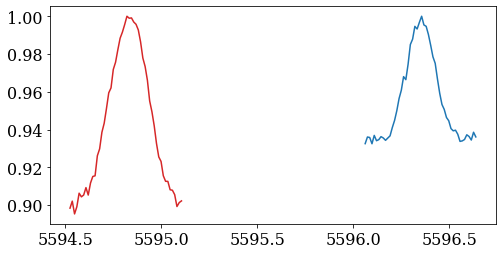

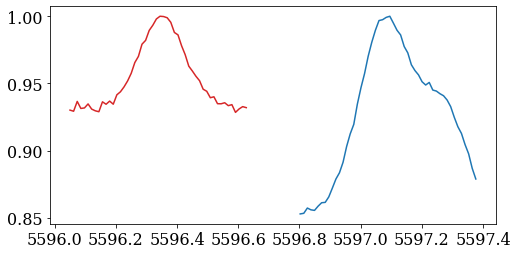

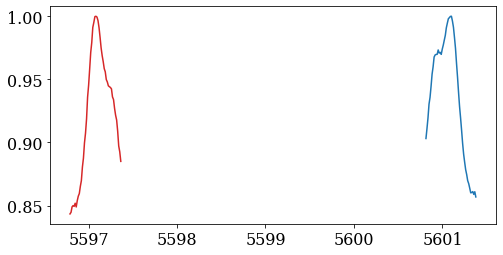

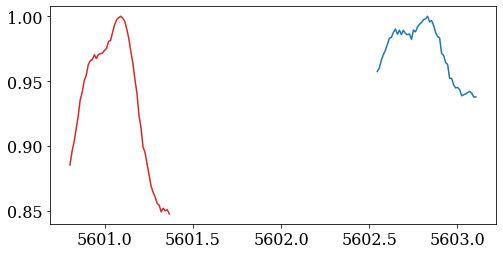

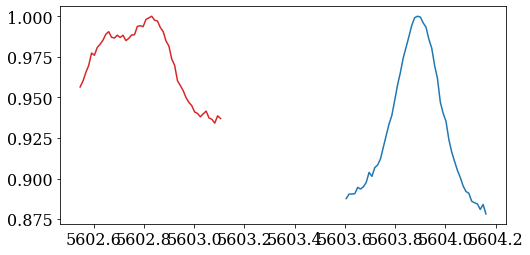

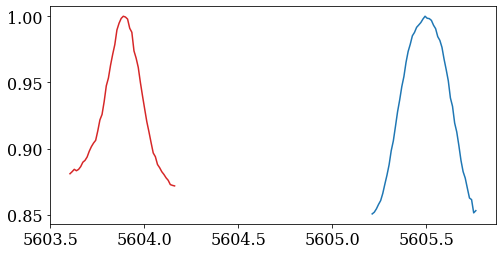

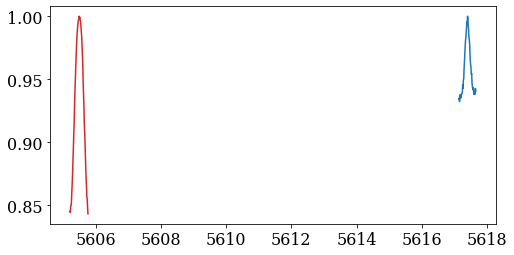

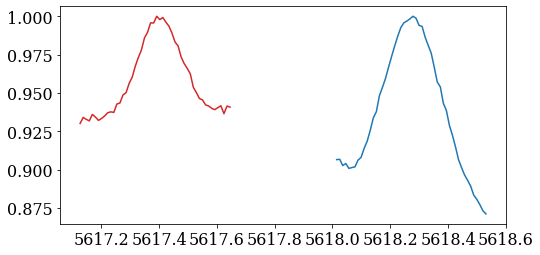

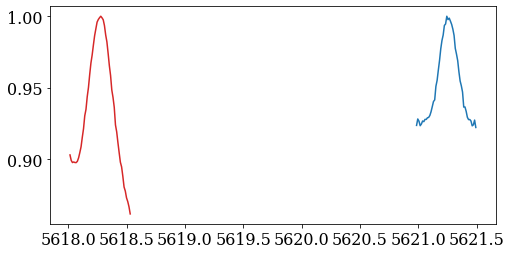

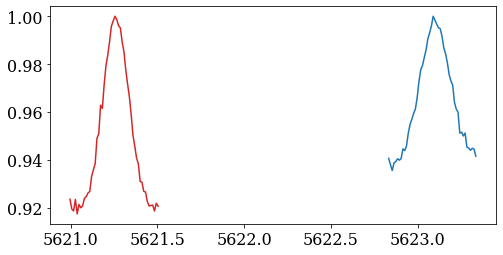

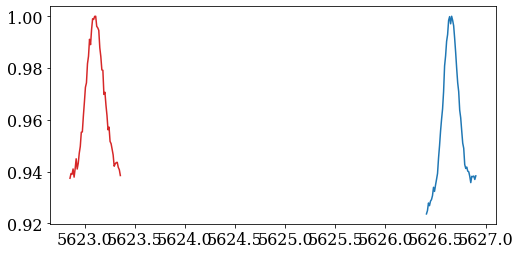

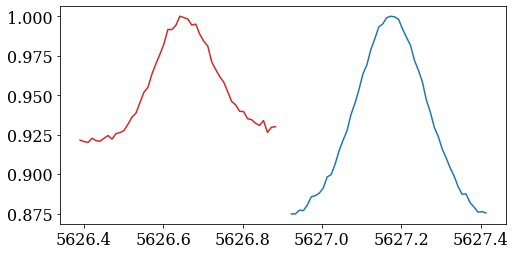

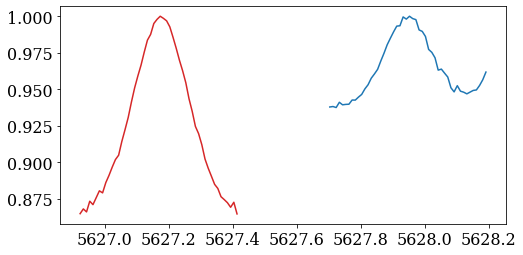

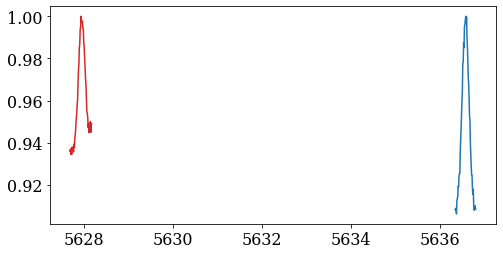

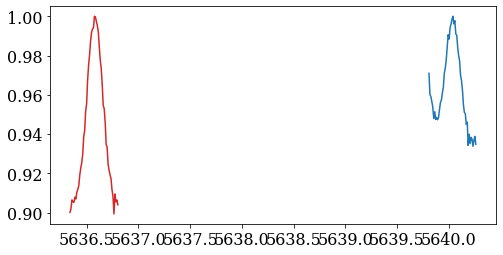

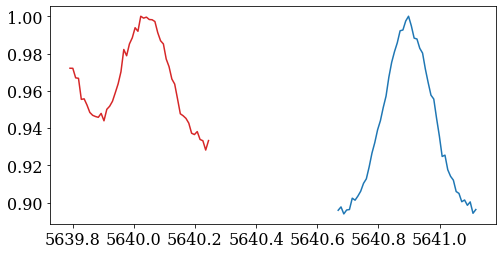

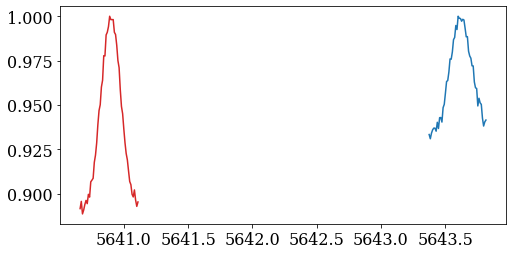

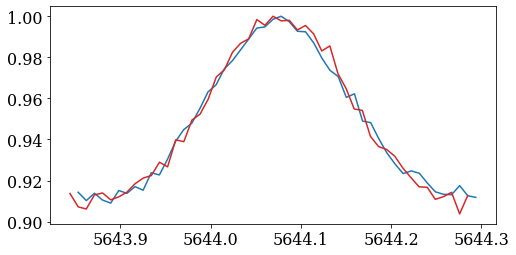

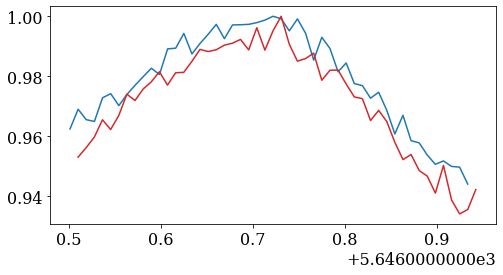

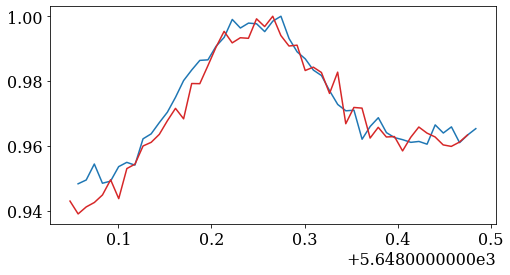

In [59]:
def plot_features_from_two_files(feature_file1, feature_file2, order):
    
    f1_features = feature_file1[:, 0]
    f1_orders = feature_file1[:, 1]

    f2_features = feature_file2[:, 0]
    f2_orders = feature_file2[:, 1]

    f1_index_of_order = np.where(f1_orders == order)[0][0]
    f2_index_of_order = np.where(f2_orders == order)[0][0]

    f1_in_order = f1_features[f1_index_of_order]
    f2_in_order = f2_features[f2_index_of_order]

    feature_len = min(len(f1_in_order), len(f2_in_order))
    print(feature_len)

    for feature in np.arange(feature_len):
        fig, ax = plt.subplots(figsize=(8, 4))
        
        x, y = f1_in_order[feature][0], f1_in_order[feature][1]
        y = y / max(y)
        ax.plot(x,y, "C0")
        
        x2, y2 = f2_in_order[feature][0], f2_in_order[feature][1]
        y2 = y2 / max(y2)
        ax.plot(x2, y2, "C3")


files = load_calib_parquets()
d1 = find_features(files[0])
d2 = find_features(files[1])
assert len(d1) == len(d2), "Number of orders between files do not match"
plot_features_from_two_files(d1, d2, 51)